# Radial basis function network
### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from keras.models import Sequential
from keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model # type: ignore
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.layers import Layer
from keras.initializers import Initializer, Constant
from sklearn.cluster import KMeans
import random

### Data loading

In [2]:
df = pd.read_csv('cocomo81_preprocessed.csv')
df.describe()

,rely,data,stor,turn,aexp,pcap,lexp,modp,loc,actual
count,63.000000,63.000000,63.00000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1.036349,1.003968,1.14381,0.971746,0.948571,0.925556,1.001429,1.004127,3.276913,4.795678
std,0.193477,0.073431,0.17942,0.080973,0.119243,0.137592,0.051988,0.130935,1.292031,1.677660
min,0.750000,0.940000,1.00000,0.870000,0.820000,0.700000,0.950000,0.820000,1.091923,1.931521
25%,0.880000,0.940000,1.00000,0.870000,0.820000,0.860000,0.950000,0.910000,2.265869,3.725621
50%,1.000000,1.000000,1.06000,1.000000,1.000000,0.860000,1.000000,1.000000,3.258097,4.595120
75%,1.150000,1.040000,1.21000,1.000000,1.000000,1.000000,1.000000,1.100000,4.110874,6.083915
max,1.400000,1.160000,1.56000,1.150000,1.290000,1.170000,1.140000,1.240000,5.764878,7.789248


### Training model

In [3]:
features = ['rely', 'data', 'stor', 'turn', 'aexp', 'pcap', 'lexp', 'modp', 'loc']
target = 'actual'
X = df[features].values
y = df[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_val.shape}')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train size: (50, 9)
X_test size: (13, 9)


In [ ]:
class InitCentersKMeans(Initializer):
    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers).fit(self.X)
        return km.cluster_centers_

# Custom RBF Layer 
class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.initializer = initializer
        self.init_betas = betas
    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.output_dim, input_shape[1]),
            initializer=self.initializer,
            trainable=True
        )
        self.betas = self.add_weight(
            name='betas',
            shape=(self.output_dim,),
            initializer=Constant(self.init_betas),
            trainable=True
        )
    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, 1)  # shape: (batch_size, 1, input_dim)
        expanded_centers = tf.expand_dims(self.centers, 0)  # shape: (1, output_dim, input_dim)
        distances = tf.reduce_sum((expanded_inputs - expanded_centers) ** 2, axis=2)
        return tf.exp(-self.betas * distances)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [11]:
model = Sequential([
    RBFLayer(13, initializer=InitCentersKMeans(X_train), betas=1.0, input_shape=(X.shape[1],)),
    Dense(1),
])

model.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer (RBFLayer)        (None, 13)                130       
                                                                 
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 144 (576.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=8,
    callbacks=[early_stopping]
)

Epoch 1/1000
7/7 [==============================] - 1s 24ms/step - loss: 26.6482 - mae: 4.8881 - val_loss: 23.4273 - val_mae: 4.5732
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 26.5205 - mae: 4.8749 - val_loss: 23.3425 - val_mae: 4.5639
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 26.4246 - mae: 4.8650 - val_loss: 23.2729 - val_mae: 4.5563
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 26.3415 - mae: 4.8564 - val_loss: 23.2018 - val_mae: 4.5486
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 26.2584 - mae: 4.8476 - val_loss: 23.1379 - val_mae: 4.5416
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 26.1796 - mae: 4.8395 - val_loss: 23.0671 - val_mae: 4.5338
Epoch 7/1000
7/7 [==============================] - 0s 5ms/step - loss: 26.0960 - mae: 4.8308 - val_loss: 22.9985 - val_mae: 4.5263
Epoch 8/1000
7/7 [==============================] - 0s 5ms/step - loss: 26.

In [13]:
first_y_pred = model.predict(X_val)
first_y_pred = first_y_pred.flatten()


mae = mean_absolute_error(y_val, first_y_pred)
rmse = root_mean_squared_error(y_val, first_y_pred)
print(f"mae {mae}\n rmse {rmse}")

1/1 [==============================] - 0s 59ms/step
mae 0.6116004773245278
 rmse 0.7663024213831675


### Applying PSO to optimize MLP hyperparameters
- Hyperparameters to be optimized
    - number of RBF centers (int)
    - beta value (float)
    - learning rate (float)
    - batch size (int)
    - optimizer (adam, sgd, rmsprop)

In [5]:
# Define bound for each parameter
param_bounds = {
    'centers': (5, 30),            
    'beta': (0.1, 10.0),          
    'learning_rate': (0.001, 0.1),
    'batch_size': (4, 32),
}
optimizer_list = ['adam', 'sgd', 'rmsprop']



# Define RBFN model building function
def build_rbfn_model(params, optimizer_name):
    model = Sequential([
        RBFLayer(int(round(params['centers'])), initializer=InitCentersKMeans(X_train), betas=params['beta'], input_shape=(X.shape[1],)),
        Dense(1),
    ])

    optimizer = {
        'adam': tf.keras.optimizers.Adam,
        'sgd': tf.keras.optimizers.SGD,
        'rmsprop': tf.keras.optimizers.RMSprop
    }[optimizer_name](learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model




# Define model evaluation function
def evaluate_model(params, optimizer_idx, k=5):
    optimizer = optimizer_list[int(round(optimizer_idx))]

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_scores = []

    for train_index, val_index in kf.split(X):
        X_train_v, X_val_v = X[train_index], X[val_index]
        y_train_v, y_val_v = y[train_index], y[val_index]
        
        scaler = StandardScaler()
        X_train_v = scaler.fit_transform(X_train_v)
        X_val_v = scaler.transform(X_val_v)
        
        model = build_rbfn_model(params, optimizer)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history = model.fit(
            X_train_v, y_train_v,
            validation_data=(X_val_v, y_val_v),
            epochs=1000,
            batch_size=int(round(params['batch_size'])),
            verbose=0,
            callbacks=[early_stopping]
        )
        val_mae = min(history.history['val_mae'])
        val_scores.append(val_mae)

    return np.mean(val_scores)




# Define particle class
class Particle:
    def __init__(self):
        self.position = {
            'centers': np.random.randint(*param_bounds['centers']),
            'beta': np.random.uniform(*param_bounds['beta']),
            'learning_rate': np.random.uniform(*param_bounds['learning_rate']),
            'batch_size': np.random.randint(*param_bounds['batch_size']),
            'optimizer_idx': random.randint(0, len(optimizer_list) - 1),
        }
        self.velocity = {key: 0 for key in self.position}
        self.best_position = dict(self.position)
        self.best_score = float('inf')




# Define pso function
# https://arxiv.org/pdf/2101.11944
def pso(n_particles=5, n_iterations=10, w=0.5, c1=1.9, c2=1.9):
    swarm = [Particle() for _ in range(n_particles)]
    global_best = {'score': float('inf'), 'position': None}

    for iteration in range(n_iterations):
        print(f"Iteration {iteration+1}/{n_iterations}", end=" ")
        for particle in swarm:
            score = evaluate_model(particle.position, particle.position['optimizer_idx'])

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = dict(particle.position)

            if score < global_best['score']:
                global_best['score'] = score
                global_best['position'] = dict(particle.position)

        for particle in swarm:
            for key in particle.position:
                r1, r2 = np.random.rand(), np.random.rand()
                cognitive = c1 * r1 * (particle.best_position[key] - particle.position[key])
                social = c2 * r2 * (global_best['position'][key] - particle.position[key])
                particle.velocity[key] = w * particle.velocity[key] + cognitive + social
                particle.position[key] += particle.velocity[key]

                if key in param_bounds:
                    low, high = param_bounds[key]
                    particle.position[key] = np.clip(particle.position[key], low, high)

                elif key.endswith('_idx'):
                    particle.position[key] = int(np.clip(particle.position[key], 0, len(optimizer_list) - 1))
        print(f"MAE: {global_best['score']}")
    return global_best

In [10]:
best_result = pso(n_particles=10, n_iterations=10)
print("Best MAE:", best_result['score'])
print("Best Hyperparameters:")
for key, value in best_result['position'].items():
    if key.endswith('_idx'):
            print("optimizer:", optimizer_list[int(round(value))])
    else:
        print(f"{key}: {value}")

Iteration 1/10 MAE: 0.8792416214942932
Iteration 2/10 MAE: 0.8105496466159821
Iteration 3/10 MAE: 0.7852431476116181
Iteration 4/10 MAE: 0.6224235892295837
Iteration 5/10 MAE: 0.5402303397655487
Iteration 6/10 MAE: 0.5233782589435577
Iteration 7/10 MAE: 0.5016001462936401
Iteration 8/10 MAE: 0.490635347366333
Iteration 9/10 MAE: 0.490635347366333
Iteration 10/10 MAE: 0.490635347366333
Best MAE: 0.490635347366333
Best Hyperparameters:
centers: 20.972370174233557
beta: 0.1
learning_rate: 0.03904237245293896
batch_size: 29.054432712871325
optimizer: adam


In [28]:
optimizer = optimizer_list[int(best_result['position']['optimizer_idx'])]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model = build_rbfn_model(best_result['position'], optimizer)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=int(round(best_result['position']['batch_size'])),
    callbacks=[early_stopping]
)

Epoch 1/1000
2/2 [==============================] - 1s 118ms/step - loss: 29.9967 - mae: 5.2045 - val_loss: 13.3912 - val_mae: 3.3039
Epoch 2/1000
2/2 [==============================] - 0s 28ms/step - loss: 11.7335 - mae: 2.9452 - val_loss: 18.2992 - val_mae: 3.5702
Epoch 3/1000
2/2 [==============================] - 0s 23ms/step - loss: 9.1580 - mae: 2.3141 - val_loss: 2.9910 - val_mae: 1.3373
Epoch 4/1000
2/2 [==============================] - 0s 21ms/step - loss: 4.0004 - mae: 1.6814 - val_loss: 4.6776 - val_mae: 1.8239
Epoch 5/1000
2/2 [==============================] - 0s 22ms/step - loss: 5.7624 - mae: 1.9934 - val_loss: 3.7538 - val_mae: 1.6388
Epoch 6/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.1446 - mae: 1.6649 - val_loss: 2.6647 - val_mae: 1.2882
Epoch 7/1000
2/2 [==============================] - 0s 25ms/step - loss: 2.5853 - mae: 1.3312 - val_loss: 5.0423 - val_mae: 1.7538
Epoch 8/1000
2/2 [==============================] - 0s 27ms/step - loss: 2.717

### Final evaluation

In [26]:
y_pred_val_log = model.predict(X_val)

# flatten to ensure it's a 1D array
y_pred_log = y_pred_val_log.flatten()

# avoid divide by 0
y_val_nonzero_log = y_val[y_val != 0]
y_pred_nonzero_log = y_pred_log[y_val != 0]

mse = mean_squared_error(y_val, y_pred_log)
mae = mean_absolute_error(y_val, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_log)

mape = np.mean(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log))

mmre = np.mean(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log))

mdmre = np.median(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log))

pred_25 = np.mean(np.abs((y_val_nonzero_log - y_pred_nonzero_log) / y_val_nonzero_log) <= 0.25)

print(f"MSE         : {mse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"RMSE        : {rmse:.4f}")
print(f"R²          : {r2:.4f}")
print(f"MAPE        : {mape * 100:.2f}%")
print(f"MMRE        : {mmre:.4f}")
print(f"MdMRE       : {mdmre:.4f}")
print(f"PRED(25)    : {pred_25 * 100:.2f}%")


print()
n_bootstraps = 500
bootstrap_metrics = {'mse': [], 'mae': [], 'r2': [], 'mape': [], 'mmre': [], 'mdmre': [], 'pred25': []}
for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_val), len(y_val), replace=True)
    y_val_boot = y_val[indices]
    y_pred_boot = y_pred_log[indices]
    bootstrap_metrics['mse'].append(mean_squared_error(y_val_boot, y_pred_boot))
    bootstrap_metrics['mae'].append(mean_absolute_error(y_val_boot, y_pred_boot))
    bootstrap_metrics['r2'].append(r2_score(y_val_boot, y_pred_boot))
    y_val_boot_nonzero = y_val_boot[y_val_boot != 0]
    y_pred_boot_nonzero = y_pred_boot[y_pred_boot != 0]
    bootstrap_metrics['mape'].append(np.mean(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero)))
    bootstrap_metrics['mmre'].append(np.mean(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero)))
    bootstrap_metrics['mdmre'].append(np.median(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero)))
    bootstrap_metrics['pred25'].append(np.mean(np.abs((y_val_boot_nonzero - y_pred_boot_nonzero) / y_val_boot_nonzero) <= 0.25))
    
print(f"MSE         : {np.std(bootstrap_metrics['mse']):.4f}")
print(f"MAE         : {np.std(bootstrap_metrics['mae']):.4f}")
print(f"RMSE        : {np.std(np.sqrt(bootstrap_metrics['mse'])):.4f}")
print(f"R²          : {np.std(bootstrap_metrics['r2']):.4f}")
print(f"MAPE        : {np.std(bootstrap_metrics['mape']) * 100:.2f}%")
print(f"MMRE        : {np.std(bootstrap_metrics['mmre']):.4f}")
print(f"MdMRE       : {np.std(bootstrap_metrics['mdmre']):.4f}")
print(f"PRED(25)    : {np.std(bootstrap_metrics['pred25'])* 100:.2f}%")

1/1 [==============================] - 0s 45ms/step
MSE         : 0.4555
MAE         : 0.5139
RMSE        : 0.6749
R²          : 0.8176
MAPE        : 14.46%
MMRE        : 0.1446
MdMRE       : 0.0888
PRED(25)    : 84.62%

MSE         : 0.1975
MAE         : 0.1236
RMSE        : 0.1496
R²          : 0.1305
MAPE        : 5.03%
MMRE        : 0.0503
MdMRE       : 0.0384
PRED(25)    : 10.11%


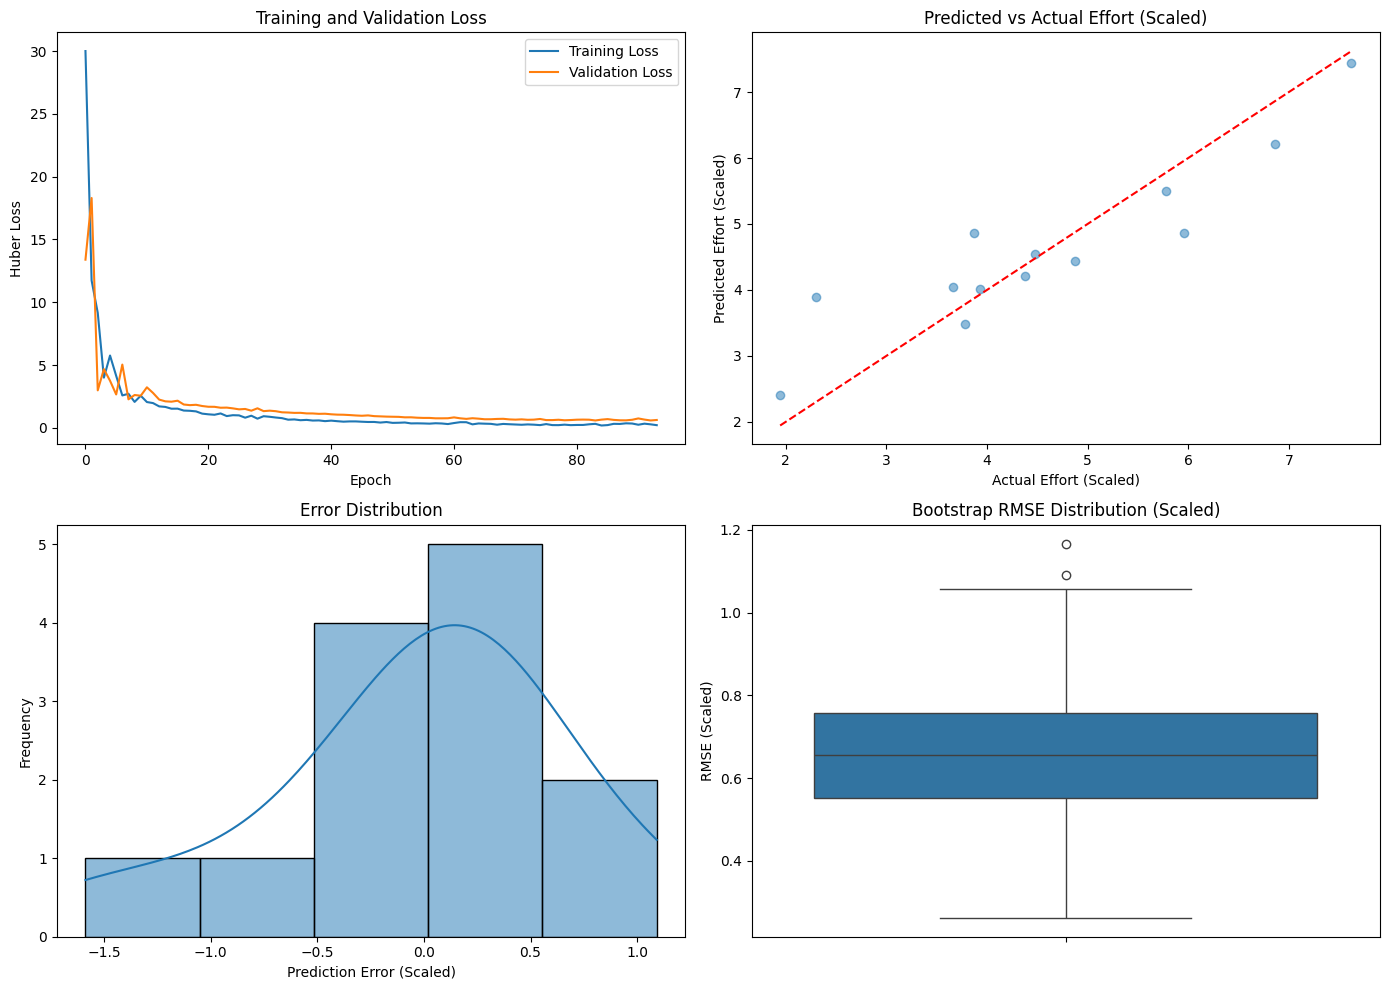

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_val, y_pred_log, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Predicted vs Actual Effort (Scaled)')
plt.xlabel('Actual Effort (Scaled)')
plt.ylabel('Predicted Effort (Scaled)')

# Error Distribution
errors = y_val - y_pred_log
plt.subplot(2, 2, 3)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error (Scaled)')
plt.ylabel('Frequency')

# Bootstrap RMSE
plt.subplot(2, 2, 4)
sns.boxplot(y=np.sqrt(bootstrap_metrics['mse']))
plt.title('Bootstrap RMSE Distribution (Scaled)')
plt.ylabel('RMSE (Scaled)')

plt.tight_layout()
plt.show()